In [138]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

hrv_middle_data_path = 'hrv-middle-data/'
measurement = 'CVSD_diff'

res = pd.DataFrame([], columns=['pcode', 'RMSSD_diff', 'CVSD_diff', 'SDNN_diff'])

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = hrv_middle_data_path + participant_key + '_hrv_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist!')
        continue

    df = pd.read_csv(file_path)
    
    if len(df) < 30:
        print(file_path + ' has too less data!')
        continue

    df['RMSSD_diff'] = df['HRV_RMSSD_after'] - df['HRV_RMSSD_before']
    df['CVSD_diff'] = df['HRV_CVSD_after'] - df['HRV_CVSD_before']
    df['SDNN_diff'] = df['HRV_SDNN_after'] - df['HRV_SDNN_before']

    # res.loc[len(res)] = [participant_key, df['RMSSD_diff'].mean(), df['CVSD_diff'].mean(), df['SDNN_diff'].mean()]
    res.loc[len(res)] = [participant_key, df['RMSSD_diff'].median(), df['CVSD_diff'].median(), df['SDNN_diff'].median()]

# res.to_csv('hrv_result.csv', index=False)

res


hrv-middle-data/P01_hrv_result.csv has too less data!
hrv-middle-data/P02_hrv_result.csv has too less data!
hrv-middle-data/P04_hrv_result.csv has too less data!
hrv-middle-data/P05_hrv_result.csv has too less data!
hrv-middle-data/P06_hrv_result.csv has too less data!
hrv-middle-data/P07_hrv_result.csv do not exist!
hrv-middle-data/P08_hrv_result.csv has too less data!
hrv-middle-data/P10_hrv_result.csv has too less data!
hrv-middle-data/P14_hrv_result.csv has too less data!
hrv-middle-data/P25_hrv_result.csv has too less data!
hrv-middle-data/P27_hrv_result.csv do not exist!
hrv-middle-data/P29_hrv_result.csv has too less data!
hrv-middle-data/P32_hrv_result.csv has too less data!
hrv-middle-data/P35_hrv_result.csv has too less data!
hrv-middle-data/P36_hrv_result.csv has too less data!
hrv-middle-data/P37_hrv_result.csv has too less data!
hrv-middle-data/P40_hrv_result.csv has too less data!
hrv-middle-data/P42_hrv_result.csv has too less data!
hrv-middle-data/P45_hrv_result.csv has

,pcode,RMSSD_diff,CVSD_diff,SDNN_diff
0,P03,-13.607373,-0.016837,-31.391035
1,P09,-21.117874,-0.023051,-12.051823
2,P11,-17.145873,-0.023131,-19.633888
3,P12,-22.014426,-0.031063,-7.326918
4,P13,-1.848798,-0.002546,1.672605
5,P15,-21.203410,-0.024389,-5.576011
6,P16,-15.369115,-0.021098,-3.156691
7,P17,-30.304626,-0.027915,-24.420655
8,P18,-2.364980,-0.007627,-2.653836
9,P19,-32.480846,-0.042566,-14.732241


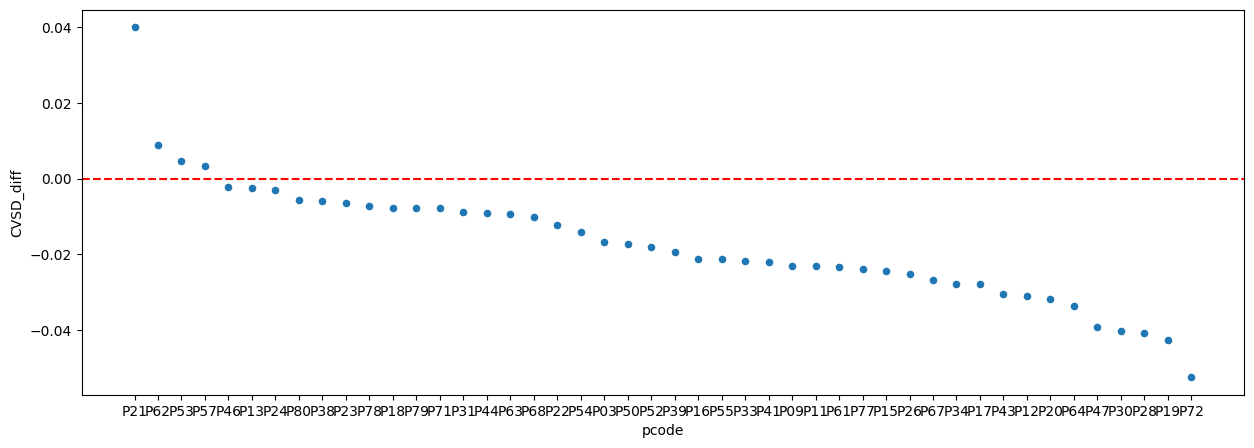

In [139]:

res.sort_values(by=measurement, ascending=False, inplace=True)
# res = res[4:64]
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))


plot.axhline(0, color='red', linestyle='--', label='y=0 line')

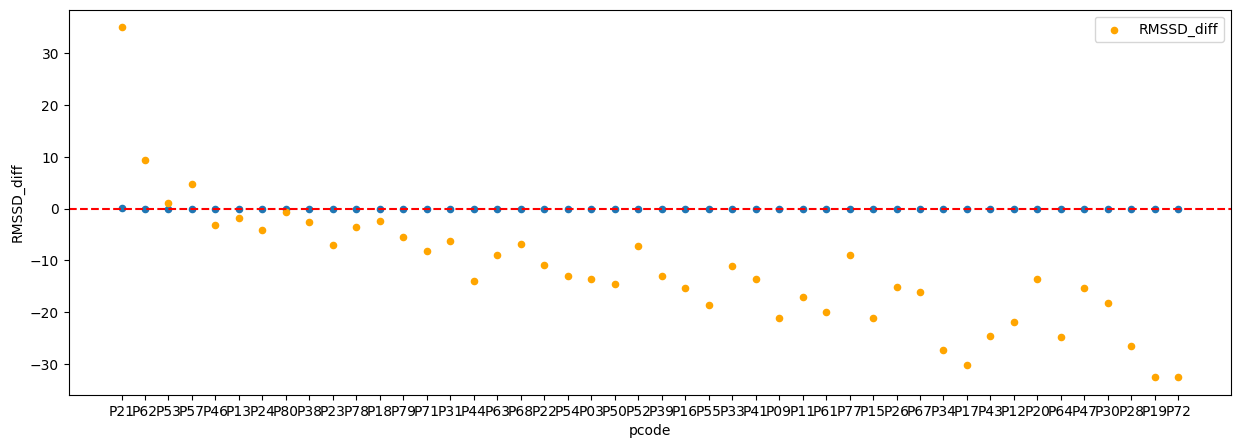

In [140]:
res.sort_values(by='CVSD_diff', ascending=False, inplace=True)
plot = res.plot(x='pcode', y='CVSD_diff', kind='scatter', figsize=(15, 5))

plot.axhline(0, color='red', linestyle='--', label='y=0 line')

res.plot(x='pcode', y='RMSSD_diff', kind='scatter', color='orange', label='RMSSD_diff', ax=plot)


plt.show()

In [141]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


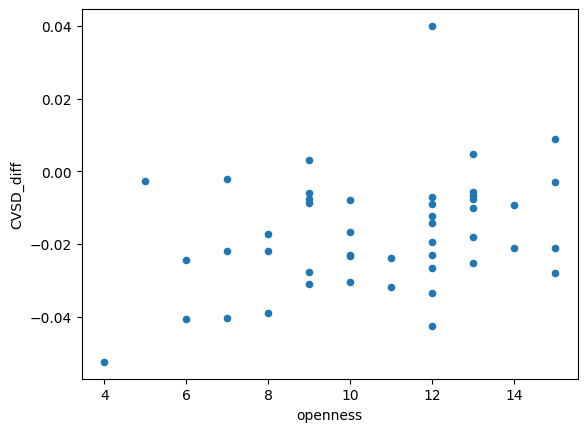

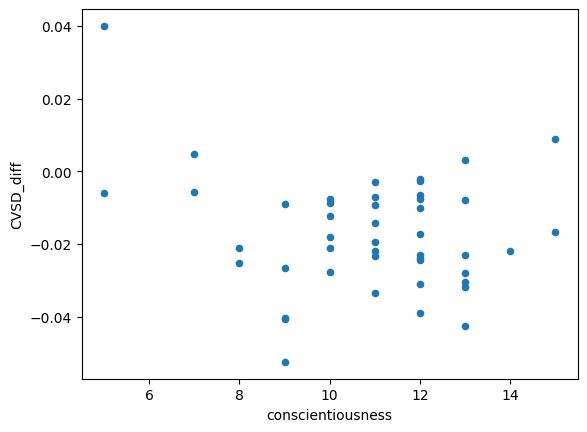

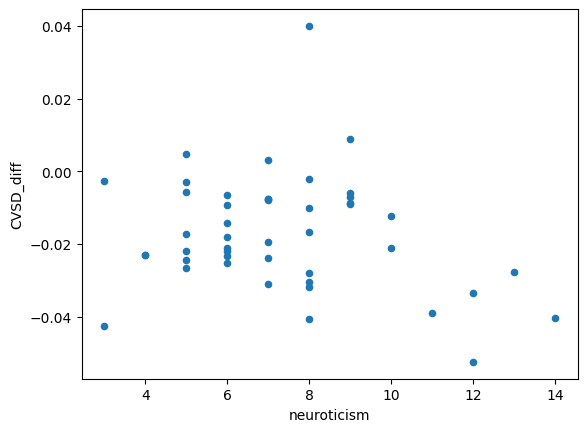

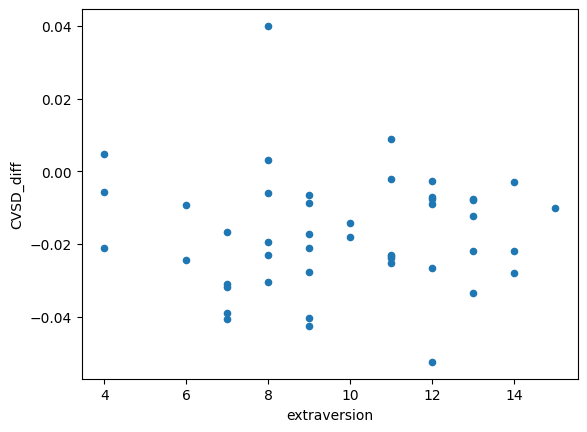

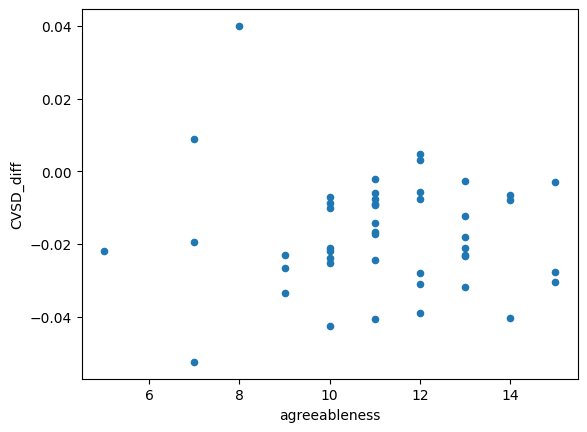

In [142]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [143]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test[measurement]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              CVSD_diff   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     1.914
Date:                Tue, 28 May 2024   Prob (F-statistic):              0.113
Time:                        11:43:28   Log-Likelihood:                 130.48
No. Observations:                  46   AIC:                            -249.0
Df Residuals:                      40   BIC:                            -238.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0052      0.02